In [1]:
import os
import pickle
from tqdm.notebook import tqdm
import sentencepiece as spm

In [2]:
# we make data from scratch (ie WebQSP dump)
source_folder = '/scratche/home/apoorv/freebase/WebQSP/data'
! ls {source_folder}

WebQSP.test.json	  WebQSP.train.json
WebQSP.test.partial.json  WebQSP.train.partial.json


In [3]:
import json
fname = os.path.join(source_folder, 'WebQSP.train.json')
train = json.load(open(fname))['Questions']
fname = os.path.join(source_folder, 'WebQSP.test.json')
test = json.load(open(fname))['Questions']

In [4]:
fname = 'data/fbwq_half_lego_cr/ent_map_fbwq_half_lego.pickle'
entity_map = pickle.load(open(fname, 'rb'))
fname = 'data/fbwq_half_lego_cr/rel_map_fbwq_half_lego.pickle'
relation_map = pickle.load(open(fname, 'rb'))

In [5]:
train[0]

{'QuestionId': 'WebQTrn-0',
 'RawQuestion': 'what is the name of justin bieber brother?',
 'ProcessedQuestion': 'what is the name of justin bieber brother',
 'Parses': [{'ParseId': 'WebQTrn-0.P0',
   'AnnotatorId': 1,
   'AnnotatorComment': {'ParseQuality': 'Complete',
    'QuestionQuality': 'Good',
    'Confidence': 'Normal',
    'FreeFormComment': 'First-round parse verification'},
   'Sparql': "PREFIX ns: <http://rdf.freebase.com/ns/>\nSELECT DISTINCT ?x\nWHERE {\nFILTER (?x != ns:m.06w2sn5)\nFILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))\nns:m.06w2sn5 ns:people.person.sibling_s ?y .\n?y ns:people.sibling_relationship.sibling ?x .\n?x ns:people.person.gender ns:m.05zppz .\n}\n",
   'PotentialTopicEntityMention': 'justin bieber',
   'TopicEntityName': 'Justin Bieber',
   'TopicEntityMid': 'm.06w2sn5',
   'InferentialChain': ['people.person.sibling_s',
    'people.sibling_relationship.sibling'],
   'Constraints': [{'Operator': 'Equal',
     'ArgumentType': 'En

In [6]:
manfix = {}
manfix['c . s . lewis'] = 'c.s. lewis'
manfix['washington d . c'] = 'washington d.c.'
manfix['m . c . escher'] = 'm.c. escher'
manfix['george h . w . bush'] = 'george h.w. bush'
manfix['aubrey o \'d ay'] = 'aubrey o\'day'
manfix['martin luther king jr .'] = 'martin luther king jr.'
manfix['w . e . b . dubois'] = 'w.e.b. dubois'

def makeQuestion(question, entity_map, relation_map):
    global manfix
    q_text = question['ProcessedQuestion']
    topic_entity_mid = question['Parses'][0]['TopicEntityMid']
    if topic_entity_mid not in entity_map:
        head = 'UNK'
    else:
        head = entity_map[topic_entity_mid]
#         print(head)
    head_mention =  question['Parses'][0]['PotentialTopicEntityMention']
    if head_mention in manfix:
        head_mention = manfix[head_mention]
    og_head_mention = head_mention
    if head_mention != None:
        if ' . ' in head_mention:
            head_mention = head_mention.replace(' . ', '. ')
        if ' \' ' in head_mention:
            head_mention = head_mention.replace(' \' ', '\'')
        if head_mention not in q_text:
#             head_mention = head_mention.replace('. ', '.')
            print(q_text, '*', og_head_mention)
            return -1
    else:
        head_mention = 'UNKNOWN'
    question_with_brackets = ''
    if head_mention not in q_text:
        question_with_brackets = q_text + '[' + head + ']'
    else:
        question_with_brackets = q_text.replace(head_mention, '[' + head + ']')
    answers = []
    for parse in question['Parses']:
        for a in parse['Answers']:
            if a['AnswerType'] == 'Entity':
                mid = a['AnswerArgument']
                if mid not in entity_map:
                    ans = a['EntityName']
                    print(mid, 'not found in entity map')
                else:
                    ans = entity_map[mid]
                answers.append(ans)
    if answers == []:
        # if no answer, try using values
        for parse in question['Parses']:
            for a in parse['Answers']:
                if a['AnswerType'] == 'Value':
                    ans = a['AnswerArgument']
                    answers.append(ans)
    if answers == []:
#         print(q_text)
        answers = ['None']
    answers_string = '|'.join(answers)
    final_string = question_with_brackets + '\t' + answers_string
    return final_string

In [7]:
train_lines = []
for id, q in enumerate(train):
    out = makeQuestion(q, entity_map, relation_map)
    train_lines.append(out)

m.0bthgtc not found in entity map
m.0bthgtg not found in entity map
m.0bzk039 not found in entity map
m.0bzk03m not found in entity map
m.0bzk03y not found in entity map
m.0bzk04b not found in entity map
m.0bzk04s not found in entity map
m.0bzk056 not found in entity map
m.0bzk05m not found in entity map
m.0bzk061 not found in entity map
m.0bzk06x not found in entity map
m.0cnd7t4 not found in entity map
m.0gy00b6 not found in entity map
m.0vnjtvt not found in entity map
m.0vnjvj3 not found in entity map
m.0vnjx36 not found in entity map
m.0vnjxtr not found in entity map
m.0vnjyrt not found in entity map
m.0zcv0sg not found in entity map


In [8]:
train_lines[:10]

['what is the name of [Justin Drew Bieber is a Canadian singer and songwriter] brother\tJaxon Bieber is the younger half-brother of Justin Bieber',
 'what character did [Natalie Portman is an Israeli-born American actress, producer, and director] play in star wars\tPadmé Amidala is a fictional character in the Star Wars universe, appearing in the prequel trilogy portrayed by actress Natalie Portman',
 'what country is the [Grand Bahama is the northernmost of the islands of the Bahamas, and the closest major island to the United States, lying 90 kilometres off the] in\tThe Bahamas /bəˈhɑːməz/, officially the Commonwealth of The Bahamas, is an island country of the Lucayan Archipelago consisting of more than 700 islands, cays, and',
 'what kind of money to take to [The Bahamas /bəˈhɑːməz/, officially the Commonwealth of The Bahamas, is an island country of the Lucayan Archipelago consisting of more than 700 islands, cays, and]\tThe dollar has been the currency of The Bahamas since 1966',

In [9]:
test_lines = []
for id, q in enumerate(test):
    out = makeQuestion(q, entity_map, relation_map)
    test_lines.append(out)

m.02q_kt_ not found in entity map
m.03hrvl not found in entity map


In [10]:
train_lines[0]

'what is the name of [Justin Drew Bieber is a Canadian singer and songwriter] brother\tJaxon Bieber is the younger half-brother of Justin Bieber'

In [11]:
train_lines[-2]

'what is the name of the [The Denver Broncos are a professional American football team based in Denver, Colorado] mascot\tThunder is the stage name for the horse who is the live animal mascot for the Denver Broncos|Miles is one of two official mascots of the Denver Broncos, an NFL football team'

In [12]:
def writeLines(lines, fname):
    f = open(fname, 'w')
    for line in lines:
        f.write(line + '\n')
    f.close()

In [13]:
fname = 'data/fbwq_half_lego_cr/qa_train_1hop.txt'
writeLines(train_lines, fname)
fname = 'data/fbwq_half_lego_cr/qa_test_1hop.txt'
writeLines(test_lines, fname)

In [35]:
import unicodedata
# add these to train lines to make mixed data

def separateEntity(question, replacement='NE'):
    start_loc = question.find('[')
    end_loc = question.rfind(']')
    entity = question[start_loc + 1: end_loc]
    final = question[:start_loc] + replacement + question[end_loc + 1:]
    return final, entity

def lineToKGCLines(line):
    line = line.split('\t')
    question, head_entity = separateEntity(line[0])
    head_entity = normalizeEntity(head_entity)
    base_line = 'predict answer: {0} | {1}'.format(head_entity, question)
    answers = line[1].split('|') # multiple entities can be answer
    answers = [normalizeEntity(a) for a in answers]
    kgc_lines = []
    for a in answers:
        kgc_lines.append(base_line + '\t' + a)
    return kgc_lines

def readLines(fname):
    f = open(fname)
    lines = []
    for line in f:
        if line[-1] == '\n':
            line = line[:-1]
        lines.append(line)
    f.close()
    return lines

def normalize(s):
    return unicodedata.normalize('NFKC', s)


def normalizeRelation(rel):
#     rel = rel.replace('_', ' ')
    rel = normalize(rel)
    rel = rel.split('.')[-1]
    rel = rel.replace('_', ' ')
    rel = rel.replace('|', ',')
    return rel

def normalizeEntity(ent):
    ent = normalize(ent)
    ent = ent.replace('|', '')
    return ent

In [17]:
source_folder = 'data/fbwq_half_lego_cr'
data = {}
hops = ['1']
for hop in hops:
    fname = os.path.join(source_folder, 'qa_train_'+ hop + 'hop.txt')
    data[hop] = readLines(fname)

In [36]:
kgc_lines_1hop = []
for line in tqdm(data['1']):
    kgc_lines_1hop.extend(lineToKGCLines(line))

In [37]:
kgc_lines_1hop[:10]

['predict answer: Justin Drew Bieber is a Canadian singer and songwriter | what is the name of NE brother\tJaxon Bieber is the younger half-brother of Justin Bieber',
 'predict answer: Natalie Portman is an Israeli-born American actress, producer, and director | what character did NE play in star wars\tPadmé Amidala is a fictional character in the Star Wars universe, appearing in the prequel trilogy portrayed by actress Natalie Portman',
 'predict answer: Grand Bahama is the northernmost of the islands of the Bahamas, and the closest major island to the United States, lying 90 kilometres off the | what country is the NE in\tThe Bahamas /bəˈhɑːməz/, officially the Commonwealth of The Bahamas, is an island country of the Lucayan Archipelago consisting of more than 700 islands, cays, and',
 'predict answer: The Bahamas /bəˈhɑːməz/, officially the Commonwealth of The Bahamas, is an island country of the Lucayan Archipelago consisting of more than 700 islands, cays, and | what kind of money

In [38]:
def writeLines(lines, fname):
    f = open(fname, 'w')
    for line in lines:
        f.write(line + '\n')
    f.close()

In [39]:
fname = 'data/fbwq_half_lego_cr/train_qa_lines.txt'
writeLines(kgc_lines_1hop, fname)

In [22]:
def getUniqueMap(init_map):
    out_map = {}
    values = set()
    for key, value in init_map.items():
        if value not in values:
            out_map[key] = value
            values.add(value)
        else:
            id_to_append = 0
            new_value = value + ' ' + str(id_to_append)
            while(new_value in values):
                id_to_append += 1
                new_value = value + ' ' + str(id_to_append)
            out_map[key] = new_value
            values.add(new_value)
    assert len(init_map) == len(set(out_map.values()))
    return out_map

def mapTriple(triple, ent_map, rel_map):
    t = triple
    new_triple = [ent_map[t[0]], rel_map[t[1]], ent_map[t[2]]]
    return new_triple

In [23]:
# uniq_ent_map = getUniqueMap(entity_map)
uniq_ent_map = entity_map

In [24]:
mapTriple(data['train'][0], uniq_ent_map, relation_map)

['Arthur Kingscote', 'place of death', 'Fulham']

In [15]:
out_folder = '/scratche/home/apoorv/transformer-kgc/data/MetaQA'
splits = ['train', 'test', 'valid']
for split in splits:
    fname = os.path.join(out_folder, split + '.txt')
    f = open(fname, 'w')
    triples = data[split]
    for t in triples:
        t = mapTriple(t, uniq_ent_map, relation_map)
        head, relation, tail = t
        input = 'predict tail: {0} | {1} |'.format(head, relation)
        output = '{}'.format(tail)
        f.write(input + '\t' + output + '\n')
        
        input = 'predict head: {0} | {1} |'.format(tail, relation)
        output = '{}'.format(head)
        f.write(input + '\t' + output + '\n')
    f.close()

In [16]:
# create entity_strings.txt which is needed in evaluation code
strings_file_name = 'entity_strings.txt'
f = open(os.path.join(out_folder, strings_file_name), 'w')
ents_uniq = set(uniq_ent_map.values())
for e in ents_uniq:
    f.write(e + '\n')
f.close()

In [17]:
def readQALines(fname):
    f = open(fname)
    questions = []
    for line in f:
        line = line.strip().split('\t')
        q = line[0]
        q = q.replace('[', '')
        q = q.replace(']', '')
        q = normalizeEntity(q)
        questions.append(q)
    return questions
        
def writeLines(lines, fname):
    f = open(fname, 'w')
    for line in lines:
        f.write(line + '\n')


In [18]:
fname = 'data/MetaQA/full_qa.txt'
questions = readQALines(fname)

In [19]:
fname = 'data/MetaQA/full_q_only.txt'
writeLines(questions, fname)

In [ ]:
vocab_size = 20000
sp = spm.SentencePieceTrainer.train(input='data/MetaQA/full_for_sp_train.txt', 
                                    model_prefix='metaqa_with_pad', vocab_size=vocab_size, 
                                    pad_id=3,
#                                     character_coverage=1.0,
#                                user_defined_symbols=['<pad>'],
#                                     normalization_rule_name='identity',
                              )

In [21]:
sp = spm.SentencePieceProcessor(model_file='data/sentencepiece/metaqa_with_pad.model')

In [22]:
sp['|']

5

In [39]:
sp.encode('about')

[4, 8811, 37]

In [92]:
lengths = []
for e in ents_uniq:
    encoded = sp.encode(e)
    lengths.append(len(encoded))

Text(0.5, 0, 'Tokenized lengths')

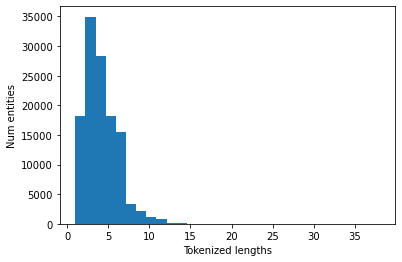

In [93]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [94]:
sp.encode('plays for')

[19, 13, 18]

In [35]:
from unidecode import unidecode
entities_ud = []
entities_ud_set = set()
for e in entities:
    ud_e = unidecode(e)
    entities_ud.append(ud_e)
    if ud_e in entities_ud_set:
        print(e, ud_e)
    else:
        entities_ud_set.add(ud_e)

University_of_Illinois_at_Urbana-Champaign University_of_Illinois_at_Urbana-Champaign
Hoang_Anh_Gia_Lai_F.C. Hoang_Anh_Gia_Lai_F.C.
Zurich Zurich
Toshirō_Mifune Toshiro_Mifune
Karl_Weierstrass Karl_Weierstrass
László_Bálint Laszlo_Balint
Sergio_Araujo Sergio_Araujo
Carlos_Tevez Carlos_Tevez
Polish-Lithuanian_Commonwealth Polish-Lithuanian_Commonwealth
Przemysl_II Przemysl_II
Christian_Groß Christian_Gross
Izmir Izmir
Münster Munster
Dalibor_Stevanovič Dalibor_Stevanovic
Jürgen_Gjasula Jurgen_Gjasula
Sócrates Socrates
Zlatko_Dedič Zlatko_Dedic
Antônio_Bezerra_Brandão Antonio_Bezerra_Brandao
Aleksander_Kwasniewski Aleksander_Kwasniewski
Sani_Bečirović Sani_Becirovic
Izmit Izmit
Ryukyu_Islands Ryukyu_Islands
Stanisław_Ulam Stanislaw_Ulam
Pantheon-Assas_University Pantheon-Assas_University
Quang_Binh_Province Quang_Binh_Province
Mures_County Mures_County
Braila Braila
San_Sebastian San_Sebastian
Ploiesti Ploiesti
Beja Beja
Zé_Antônio Ze_Antonio
San_Miguel_de_Tucumán San_Miguel_de_Tucuman
F

In [28]:
len(entities), len(set(entities))

(123182, 123182)

In [33]:
len(entities_ud), len(set(entities_ud))

(123182, 123145)